### Недообучение и переобучение

#### Цель работы

Познакомиться с основными проблемами обобщающей способности алгоритмов машинного обучения: overfitting (переобучение) и underfitting (недообучение).

#### Задания для выполнения

1. Загрузите первые 400 строк прилагающегося датасета `diabetes.csv`.
2. Сделайте количественное описание датасета: число признаков, статистику по признакам.
3. Отделите целевую переменную `Outcome`.
4. Разделите данные на обучающую и валидационную выборки при помощи `train_test_split` из библиотеки `sklearn.model_selection` в соотношении 80-20 (для этого укажите параметр test_size=0.2) с перемешиванием, указав значение параметра `random_state=42`.
5. Создайте объект `DecisionTreeClassifier(random_state=1)`. Обучите модель на обучающих (трейновых) данных. Сделайте предсказание на трейновом и валидационном наборе признаков. Выведите значения метрики `f1-score`для трейнового и валидационного наборов данных. По полученным значениям метрик сделайте предположение о переобученности модели.
6. Произведите кросс-валидацию с использованием функции `cross_validate` из библиотеки  `sklearn.model_selection`. По полученным данным, постройте график зависимости значений `f1-score` от набора данных соответствующей итерации. По графику убедитесь в том, что имеет место переобученность модели.
7. Для борьбы с переобучением регуляризуйте модель `DecisionTreeClassifier`, уменьшив глубину дерева, указав параметр регуляризации `max_depth=3`.
8. Снова проделайте пункт 6 с учётом регуляризации и убелитесь по графику в том, что модель больше не является переобученной.
9. Теперь рассмотрите проблему недообучения модели. Для борьбы с недообучением модели добавьте данные.
Для этого загрузите все строки датасета `diabetes.csv`.
10. Обучите модель `DecisionTreeClassifier(random_state=1, max_depth=3)` на всех данных и убедитесь в том, что значение метрики `f1-score` улучшилось.

#### Методические указания

Как всегда загружаем стандартный набор необходимых библиотек:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

##### Диагностика моделей классификации

Для первого примера воспользуемся синтетическими данными. Сгенерируем большой и достаточно сложный датасет для классификации. В нем будет 10 тысяч точек и 500 атрибутов. Из них всего 50 признаков будут информативными. Сразу после генерации разделим получившийся датасет на обучающую и тестовую выборки:

In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=10000, n_features=500, 
                           n_informative=50, n_repeated=0, 
                           class_sep=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=3)

Обучим на этом наборе данных самую простую модель - логистическую регрессию. Выведем оценки точности этой модели на обучающей и тестовой выборке:

In [6]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.8413
Test score: 0.8056


В данном случае мы используем метрику эффективности классификации по умолчанию. В зависимости от задания вы можете проводить анализ по любой интересующей вас метрике. Получаем такие оценки эффективности данной модели:

То, насколько отличается обучающая и тестовая эффективность модели - основной индикатор пере- или недообучения. Мы явно видим, что тестовая эффективность полученной модели неидеальна. Определить, что является причиной снижения качества модели - ее излишняя или недостаточная вариативность - основная цель диагностики модели машинного обучения.

Но по одним этим показателям очень сложно понять, в какой из двух ситуаций мы находимся. Поэтому прибегнем к построению кривых обучения. Это даст нам больше информации о том, каков уровень сложности модели по отношению к данным. Воспользуемся готовой реализацией построения кривых обучения из библиотеки продвинутой визуализации для машинного обучения _yellowbrick_:

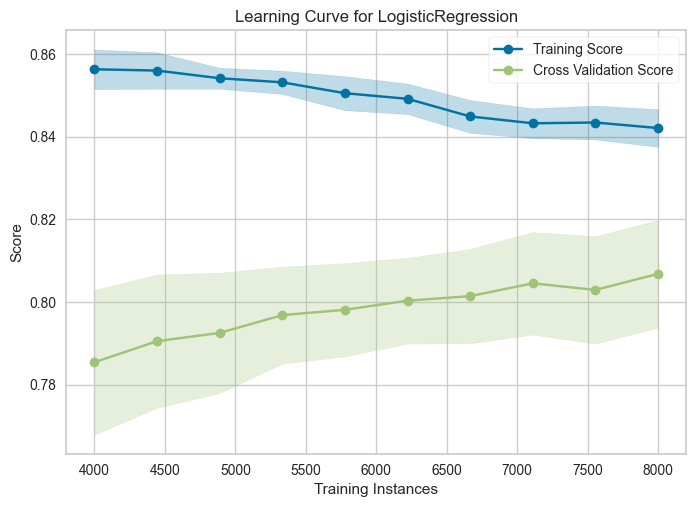

In [7]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(
    LogisticRegression(), train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y).show()

Здесь мы задаем модель, которую хотим проверить и набор долей обучающей выборки, по которым будем ее обучать. В данном случае, эта функция построит модели логистической регрессии, обученные на 10%, 20%, и так далее до 100% обучающей выборки. А затем по каждой модели будет вычислена обучающая и тестовая эффективности. И эти показатели будут изображены на графике, то есть кривой обучения:

Эта кривая показывает, что когда модель учится на небольшом объеме данных, она имеет прекрасную обучающую эффективность, но плохую тестовую. По мере увеличения объема обучающей выборки, эти эффективности сближаются, но между ними все еще сохраняется зазор.

Напомним, что большой промежуток между тестовой и обучающей эффективностью свидетельствует о переобучении. А низкое значение обучающей эффективности - о недообучении. Так что из этого присутствует в данной модели? Можно предположить, что модель немного переобучается. В пользу этого говорит и то, что наш исходный датасет очень разреженный (хотя мы об этом знаем только потому, что его сгенерировали). Более точно можно будет сказать сравнив эту модель с другими. Самый простой способ - использовать регуляризацию.

МЫ воспользуемся классификатором на основе гребневой регрессии. Вспомним, что обычный метод наименьших квадратов (воплощением которого является модель логистической регрессии) эквивалентна гребневой модели с параметром регуляризации, равном нулю. Чем больше этот параметр, тем больше регуляризации в модели и тем проще получаемые модели. Если мы предполагаем, что наша исходная модель переобучалась, то давайте построим и оценим модель с большим значением параметра регуляризации:

In [8]:
from sklearn.linear_model import RidgeClassifier
lr = RidgeClassifier(alpha=1000000).fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.7724
Test score: 0.7712


При таком огромном значении регуляризации мы почти гарантированно получим недообученную модель. Поэтому полезно будет сравнить результаты модели выше с этими. Вот что получилось у очень регуляризованной модели:

Обратите внимание, что эффективность стала заметно ниже. Плюс, значения почти совпадают. То есть, почти никакой разницы не осталось. Это подтверждает наш первоначальный вывод о том, что в первой модели разница между обучающей и тестовой эффективностью получилась довольно большой для данной задачи. Построим кривые обучения для нашей второй модели:

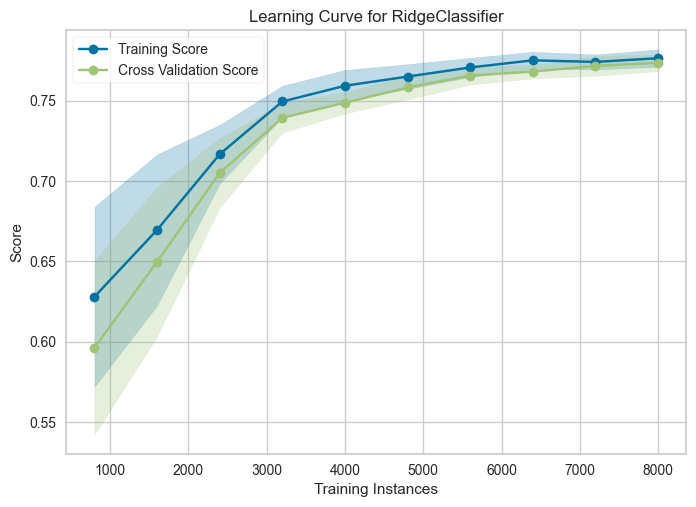

In [9]:
visualizer = LearningCurve(
    RidgeClassifier(alpha=1000000), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y) .show()

Получилась совсем другая картина:

При анализе таких графиков надо обязательно обращать внимание на масштаб вертикальной оси. Несмотря на то, что кажется, будто значения в правой части графика (а нам интересны в первую очередь именно конечные значения эффективности, остальные - это просто предыстория) сильно больше, чем на первом, на самом деле они ниже. Данный график очень характерен для недообучения - низкие значения эффективности и практически никакой разницы между тестовой и обучающей эффективностью.

Если нерегуляризованная модель переобучается, а регуляризованная - недообучается, то где-то в промежутке есть оптимальная модель, котор

Для того, чтобы проанализировать данную задачу еще более глубоко построим график зависимости эффективности модели от значения параметра регуляризации. Для этого воспользуется логравномерным распределением:

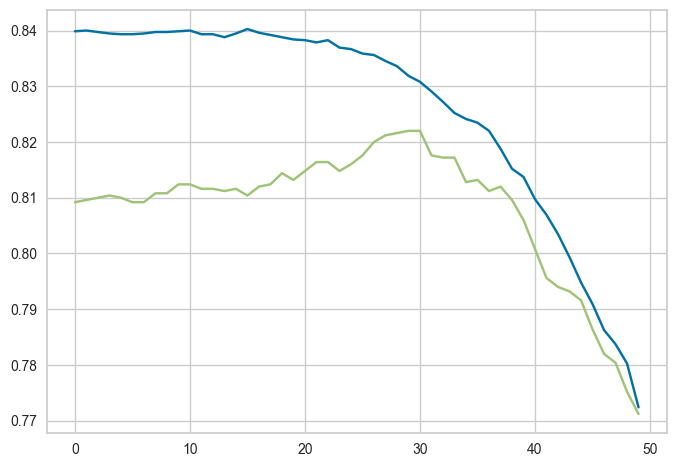

In [10]:
from sklearn.linear_model import RidgeClassifier
trains = []
tests = []
for i in np.logspace(2, 6, 50):
  ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
  trains.append(ridge.score(X_train, y_train))
  tests.append(ridge.score(X_test, y_test))

plt.plot(trains)
plt.plot(tests)

Данный код построит 50 моделей, различающихся только параметром регуляризации. Он будет лежать в диапазоне от 100 ($10^2$) до 100 000 ($10^6$). Диапазон подбирается эмпирически, интересующий нас интервал значений параметров регуляризации будет разный в других задачах. Поэтому рекомендуется сначала построить модели в очень широких пределах (скажем, от -6 до 6), а затем сужать его настолько, чтобы на графике наглядно проявилась примерно такая картина:

Здесь мы видим, что при определенных значениях параметра регуляризации тестовая эффективность модели (а нас в конечном итоге интересует именно она) лучше, чем во всех остальных. Подбором или алгоритмически можно найти такое оптимальное значение параметра регуляризации. Оно дает нам модель, которая имеет оптимальный уровень сложности для данного конкретного датасета. Давайте выведем получившиеся показатели:

In [11]:
from sklearn.linear_model import RidgeClassifier
lr = RidgeClassifier(alpha=26500).fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.8311
Test score: 0.8228


Эта модель получилась немного лучше, чем самая первая, модель логистической регрессии:

Это произошло потому, что мы за счет регуляризации убрали негативный эффект переобучения. Давайте построим кривые обучения, чтобы посмотреть, как они выглядят для "хорошей" модели:

Опять же, с оглядкой на масштаб вертикальной оси мы видим, что и уровень эффективности выше, чем в первой модели и разница между двумя эффективностями тоже сократилась. И то и другое - это свидетельство большей обобщающей способности модели.

##### Диагностика моделей регрессии

Для более реалистичного примера загрузим датасет цен на недвижимость:

In [12]:
from numpy import genfromtxt
dataset = pd.read_csv('BostonHousing.csv', sep=',').dropna().values


X = dataset[:,:-1]
y = dataset[:,-1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

In [13]:
'''from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)'''

X_train_poly = X_train
X_test_poly = X_test

Это набор данных для решения задачи регрессии - предсказания цен объектов недвижимости по их характеристикам. Самостоятельно изучите данный датасет, приведите его численные показатели. А мы сразу выведем оценку эффективности простой модели - линейной регрессии:

Большой разрыв между обучающей и тестовой эффективностью также сразу должен навести на мысль о переобучении данной модели. Попробуем проверить наше предположение при помощи кривых обучения (обратите внимание, что мы сразу используем гребневую модель с очень маленькой регуляризацией):

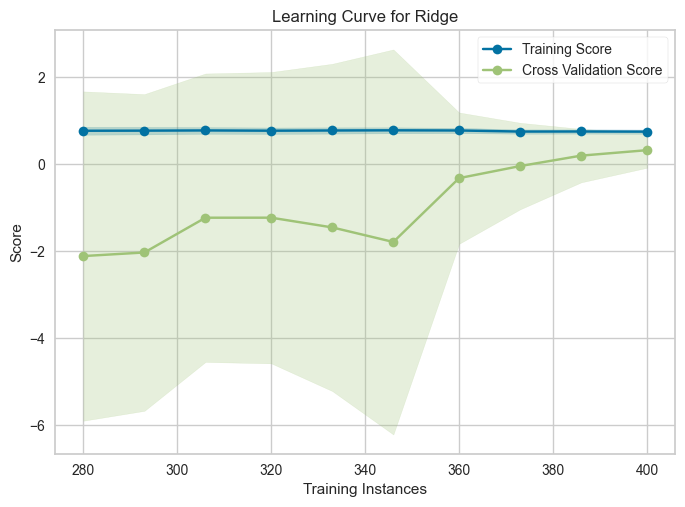

In [14]:
from yellowbrick.model_selection import LearningCurve
from sklearn.linear_model import Ridge

visualizer = LearningCurve(
    Ridge(alpha=0.0001), scoring='r2', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X, y) .show()

Может потребоваться несколько попыток, чтобы заставить график выглядеть показательно (может понадобится изменить масштаб по разным осям), но в итоге мы можем наблюдать примерно такой график:

Обратите внимание, что промежуток между обучающей и тестовой эффективностью все равно очень большой в правой части графика, хоть чисто визуально и не выглядит таковым. Просто тестовая эффективность в левой части графика просто ужасна, и она сильно смещает вертикальную ось вниз. Тем не менее, можно обоснованно предположить, что такая модель переобучается на имеющихся данных.

Сразу построим график зависимости эффективности модели от значения параметра L2-регуляризации:

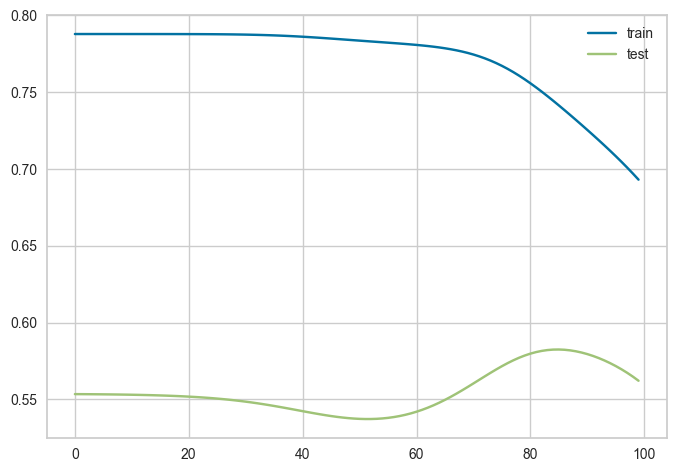

In [15]:
from sklearn.linear_model import Ridge
trains = []
tests = []
for i in np.logspace(-2, 3, 100):
  ridge = Ridge(alpha=i).fit(X_train_poly, y_train)
  trains.append(ridge.score(X_train_poly, y_train))
  tests.append(ridge.score(X_test_poly, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()

Получаем такой очень характерный график регуляризации:

На этом графике очень наглядно виден характер кривых регуляризации. В левой области лежат значения, которые дают слишком сложные модели. Они хорошо описывают обучающую выборку, но не обобщаются на тестовую. Это зона переобучения. В правой области - значения, порождающие слишком простые модели. Они одинаково плохо описывают и обучающую и тестовые выборки. Это зона недообучения. Посередине между ними лежит оптимальный уровень сложности модели для данного конкретного датасета. Здесь эта оптимальность очень хорошо выражена.

Численно можно подобрать оптимальное значение параметра регуляризации для гребневой регрессии. Давайте выведем эффективность такой оптимальной модели:

In [16]:
lr = Ridge(alpha=0.18).fit(X_train, y_train)

print(f"Linear Regression-Training set score: {lr.score(X_train, y_train):.2f}")
print(f"Linear Regression-Test set score: {lr.score(X_test, y_test):.2f}")

Linear Regression-Training set score: 0.79
Linear Regression-Test set score: 0.55


Для такой модели получаем следующие значения:

Можно видеть, что они значительно выше, чем у первой модели. Опять же, мы оптимизировали модель за счет борьбы с ее переобучением. Давайте построим кривую обучения данной модели:

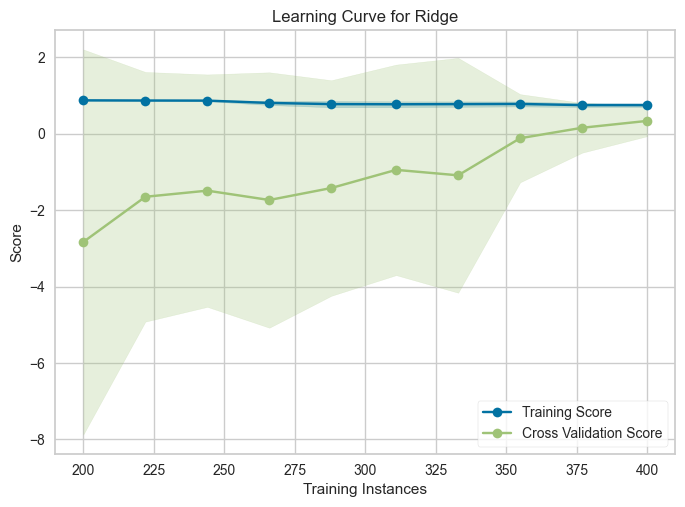

In [17]:
visualizer = LearningCurve(
    Ridge(alpha=0.18), scoring='r2', train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y) .show()

Опять же, вся разница между кривыми обучения лежит в масштабе вертикальной оси. По сравнению с предыдущим графиком этот выглядит гораздо более адекватно.

Здесь можно заметить, что несмотря на то, что мы подобрали наилучший уровень сложности модели, ее эффективность все равно не идеальна. Присутствует и разница между тестовой и обучающей эффективностью. Это свидетельствует о том, что и в нашей самой лучшей модели все равно имеется и bias и variance в какой-то степени. И хоть мы нашли лучшую модель, она лучшая из одного отдельного класса моделей - гребневой регрессии.

Поэтому можно исследовать на этом же датасете и другие модели. Так, например, можно попробовать другой вид регуляризации - лассо. В библиотеке sklearn эта модель работает только как регрессор, то есть она не подходит для задач классификации. Поэтому мы не могли использовать ее в предыдущем примере. Сразу построим кривые регуляризации:

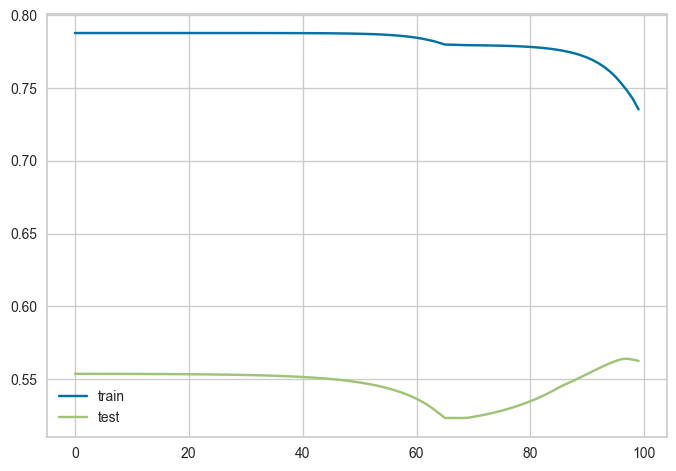

In [18]:
from sklearn.linear_model import Lasso
trains = []
tests = []
for i in np.logspace(-4, 0, 100):
  ridge = Lasso(alpha=i).fit(X_train, y_train)
  trains.append(ridge.score(X_train, y_train))
  tests.append(ridge.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()

Получается такой график тоже с отчетливыми зонами пере- и недообучения:

Точно также можно исследовать и другие виды моделей. Итого для диагностики моделей используется три инструмента:

- сравнение обучающей и тестовой эффективности
- анализ формы кривых обучения
- построение кривых по одному из гиперпараметров модели, который влияет на соотношение bias/variance

Но главное - это сравнение между собой нескольких моделей одного типа, но с разным уровнем сложности (еще говорят про модели с разной склонностью к пере- или недообучению).

##### Диагностика на реальных данных

В реальных задачах диагностика моделей машинного обучения может быть не настолько очевидной. Зачастую используются модели, которые не используют регуляризацию в явном виде. В этом примере рассмотрим приемы диагностики моделей на реальных данных. Будем использовать известный датасет для классификации "Диабет"

Загружаем данные:

In [19]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/koroteevmv/ML_course/2023/ML4.3%20diagnostics/diabetes.csv',nrows=200)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Обратите внимание, что мы считали только первые 200 строк из файла. Этим мы имитируем обучение на части данных. Формируем обучающую и тестовую выборки:

In [20]:
target = "Outcome"
y = df[target]
X = df.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Для моделирования выберем совершенно другой тип модели - решающие деревья. Создадим объект модели дерева решений и исследуем его эффективность:

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 1.0000
Test score = 0.5500


Получаем следующий очень показательный результат:

Даже без построения кривых обучения здесь очевидно переобучение модели. Но все же для тренировки распознавания разных ситуаций на графике построим кривую обучения:

У деревьев решений один из параметров - максимальная глубина дерева как раз и влияет на склонность модели к переобучению. Аналогом регуляризации для деревьев будет искусственное ограничение максимальной глубины дерева. Давайте построим кривую обучения для такого регуляризованного дерева:

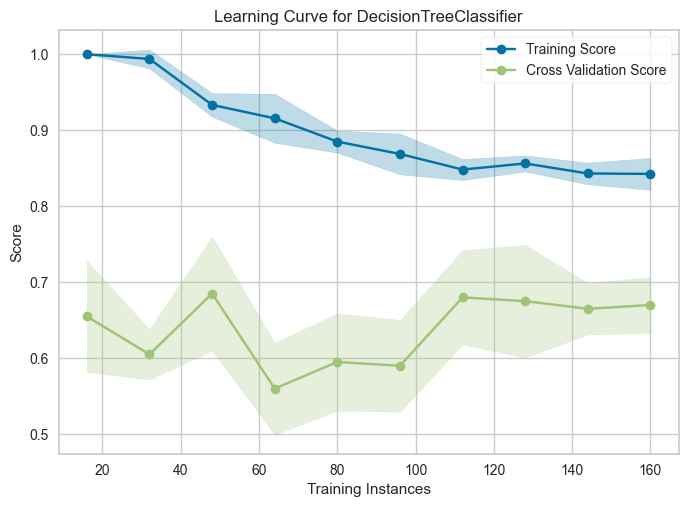

<Axes: title={'center': 'Learning Curve for DecisionTreeClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [22]:
visualizer = LearningCurve(
    DecisionTreeClassifier(max_depth=4), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y)
visualizer.show()

Получается гораздо более качественная картина:

Выведя метрики эффективности получаем более высокое качество модели на тестовых данных:

Введение регуляризации, искусственное упрощение моделей - не единственный способ борьбы с переобучением. Самый лучший способ - это обучение на более полном датасете, то есть добавление большого количества данных. В этом примере мы специально не использовали весь имеющийся набор данных. На части модель сильно переобучается, но чем больше данных, тем меньше модели (даже одинаковые по сложности) становятся склонными к переобучению.

Для иллюстрации этого повторим обучение нерегуляризованного дерева решений на всем датасете:

In [23]:
df = pd.read_csv('https://raw.githubusercontent.com/koroteevmv/ML_course/2023/ML4.3%20diagnostics/diabetes.csv')
target = "Outcome"
y = df[target]
X = df.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
from sklearn.metrics import f1_score
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 1.0000
Test score = 0.7273


В итоге мы получаем такие метрики эффективности:

Получившаяся модель значительно лучше, чем даже регуляризованное дерево. В общем случае, добавление данных работает лучше, чем регуляризация.

##### Диагностика недообучения

До сих пор мы рассматривали примеры, в которых модели по умолчанию демонстрируют явное переобучение. Но на практике чаще сталкиваются с недообучением, так как начинают анализ с более простых моделей, которые как раз склонны именно к недообучению. Рассмотрим в качестве примера более сложный датасет.

В sklearn есть встроенный механизм загрузки датасетов из онлайн репозитория OpenML. Возьмем оттуда датасет, посвященный проблеме управления истребителем F16:

In [24]:
from sklearn.datasets import fetch_openml
data = fetch_openml(name='delta_ailerons', parser="auto")
data.data.shape

(7129, 5)

Он состоит из более 7 тысяч строк:

Сформируем обучающую и тестовую выборки:

In [25]:
X = pd.get_dummies(data.data)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Создадим и оценим простую модель логистической регрессии:

In [26]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 0.6092
Test score = 0.5989


Получаем следующие метрики:

Построим кривую обучения данной модели:

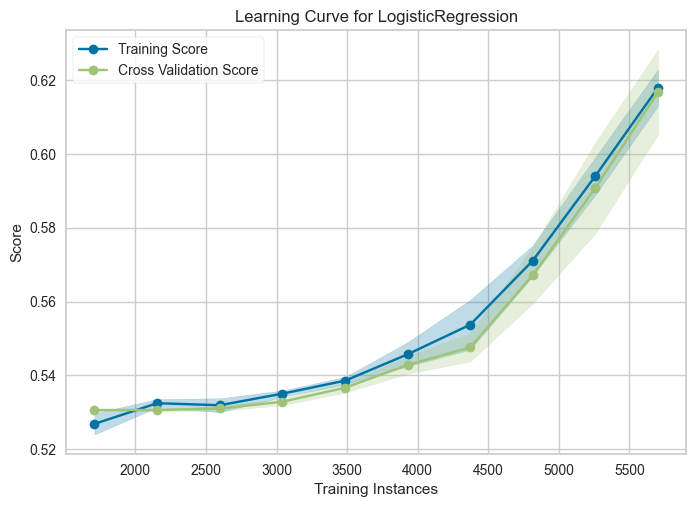

In [27]:
visualizer = LearningCurve(
    LogisticRegression(), scoring='accuracy', train_sizes=np.linspace(0.3, 1.0, 10)
).fit(X, y) .show()

Здесь очевидны признаки недообучения: низкий уровень обучающей эффективности, малый разрыв между обучающей и тестовой эффективностью. При недообучении регуляризация не поможет, даже навредит, так как еще усилит его. Поэтому единственный путь в этом случае - использовать более сложные, вариативные модели. Можно, например, попробовать многослойный перцептрон:

In [28]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 0.9392
Test score = 0.9383


Самого главного мы добились - эффективность модели сильно выросла. Но давайте построим график обучения:

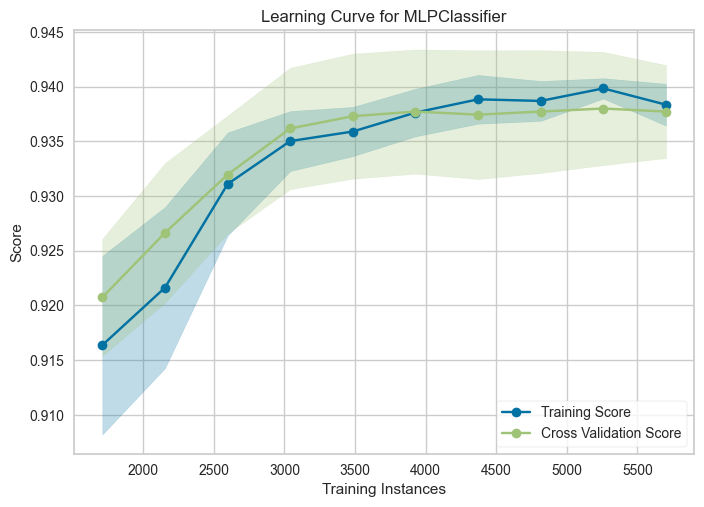

In [29]:
visualizer = LearningCurve(
    MLPClassifier(), scoring='accuracy', train_sizes=np.linspace(0.3, 1.0, 10)
).fit(X, y) .show()

![Кривая обучения перцептрона](https://github.com/koroteevmv/ML_course/blob/main/ML4.4%20diagnostics/img/ml43-12.png?raw=true)

Кроме использования более вариативных моделей самих по себе можно ввести в модель полиномиальные признаки:

In [30]:
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
model = RidgeClassifier(alpha=0.001).fit(PolynomialFeatures(2).fit_transform(X_train), y_train)
y_train_pred = model.predict(PolynomialFeatures(2).fit_transform(X_train))
y_pred = model.predict(PolynomialFeatures(2).fit_transform(X_test))
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 0.9392
Test score = 0.9362


Полиномиальные модели являются естественным усложнением линейных и поэтому в случае недообучения исходной модели почти всегда обеспечивают увеличение эффективности модели:

Для этой полиномиальной модели уже можно пробовать использовать регуляризацию и строить соответствующие кривые:

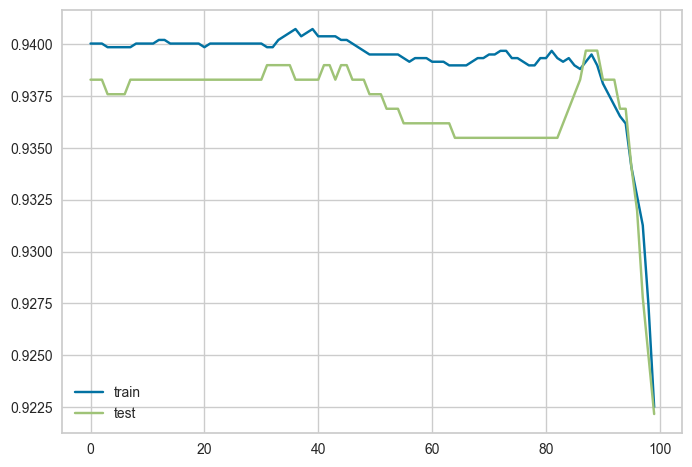

In [31]:
from sklearn.linear_model import RidgeClassifier
trains = []
tests = []
for i in np.logspace(-7, 0, 100):
  ridge = RidgeClassifier(alpha=i).fit(PolynomialFeatures(2).fit_transform(X_train), y_train)
  trains.append(ridge.score(PolynomialFeatures(2).fit_transform(X_train), y_train))
  tests.append(ridge.score(PolynomialFeatures(2).fit_transform(X_test), y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()

В этом примере (как и во многих других реальных случаях) кривая регуляризации уже не такая очевидная и легко читаемая. Но и на ней можно при желании разглядеть область недообучения справа. Область переобучения здесь просматривается не так четко, так как тестовая эффективность практически не падает с уменьшением параметра регуляризации:

Также можно заметить, что этот график уже не такой гладкий и ровный, как в предыдущих примерах. На нем присутствуют скачки, неравномерности. Это все случайные отклонения, которые обусловлены и артефактами в самих данных, и стохастичностью процесса обучения сложных моделей и случайными ошибками выборки, возникшими при разделении датасета на тестовую и обучающую выборки.

#### Задания для самостоятельного выполнения

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.datasets import make_classification,make_regression, fetch_openml
from sklearn.model_selection import learning_curve, GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

##### 1. Повторите диагностику модели классификации синтетических данных с использованием других метрик эффективности - precision, recall, F1. Как изменились результаты?

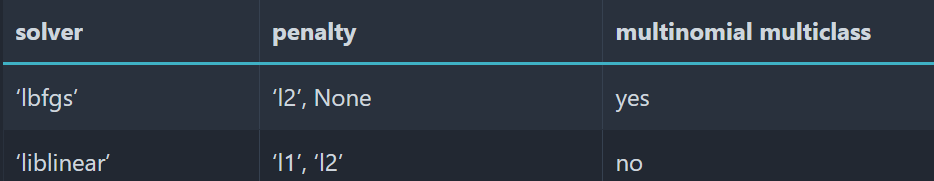

In [33]:
# Генерация синтетического датасета
X, y = make_classification(n_samples=10000, n_features=500, 
                           n_informative=50, n_redundant=0, 
                           class_sep=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=3)

# Обучение модели логистической регрессии
lr = LogisticRegression(max_iter=1000, solver='liblinear')
lr.fit(X_train, y_train)

# Предсказания
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Вычисление метрик
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")

print(f"Training Precision: {train_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}\n")

print(f"Training Recall: {train_recall:.4f}")
print(f"Test Recall: {test_recall:.4f}\n")

print(f"Training F1: {train_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")


Training Accuracy: 0.8471
Test Accuracy: 0.7936

Training Precision: 0.8418
Test Precision: 0.7976

Training Recall: 0.8563
Test Recall: 0.7847

Training F1: 0.8490
Test F1: 0.7911


##### 2. Повторите диагностику модели регрессии с использованием других видов моделей:

######  1. метода опорных векторов (исследуйте влияние параметра С на недо-и переобучение)

C=0.1: Train R2=0.0092, Test R2=0.0091
C=1: Train R2=0.0936, Test R2=0.0894
C=10: Train R2=0.7021, Test R2=0.6804
C=100: Train R2=0.9713, Test R2=0.9185
C=1000.0: Train R2=1.0000, Test R2=0.9279
C=10000.0: Train R2=1.0000, Test R2=0.9278
C=100000.0: Train R2=1.0000, Test R2=0.9278
C=1000000.0: Train R2=1.0000, Test R2=0.9278


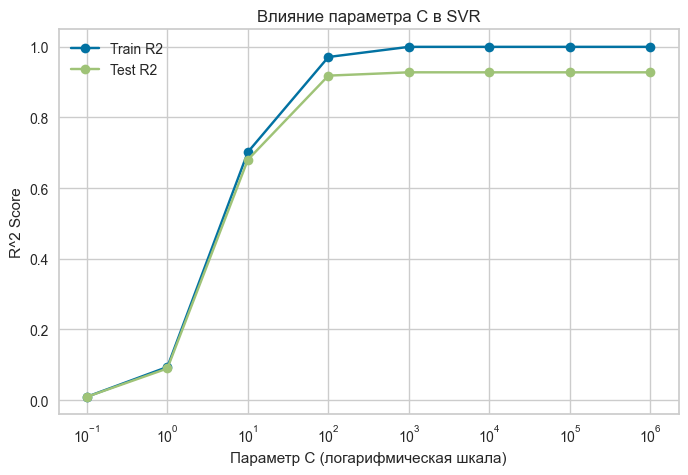

In [ ]:
# Генерация синтетического датасета для регрессии
X, y = make_regression(n_samples=1000, n_features=20, noise=15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C_values = [0.1, 1, 10, 100, 1e3, 1e4, 1e5,1e6]
train_scores = []
test_scores = []

for C in C_values:
    svr = SVR(C=C, kernel='rbf')
    svr.fit(X_train, y_train)
    y_train_pred = svr.predict(X_train)
    y_test_pred = svr.predict(X_test)
    train_scores.append(r2_score(y_train, y_train_pred))
    test_scores.append(r2_score(y_test, y_test_pred))
    print(f"C={C}: Train R2={train_scores[-1]:.4f}, Test R2={test_scores[-1]:.4f}")

# Построение графика зависимости R^2 от параметра C
plt.figure(figsize=(8, 5))
plt.plot(C_values, train_scores, label='Train R2', marker='o')
plt.plot(C_values, test_scores, label='Test R2', marker='o')
plt.xscale('log')
plt.xlabel("Параметр C (логарифмическая шкала)")
plt.ylabel("R^2 Score")
plt.title("Влияние параметра C в SVR")
plt.legend()
plt.show()

###### 2. метода ближайших соседей (исследуйте влияние количества соседей)

n_neighbors=1: Train R2=1.0000, Test R2=0.2975
n_neighbors=2: Train R2=0.7989, Test R2=0.4750
n_neighbors=3: Train R2=0.7537, Test R2=0.5607
n_neighbors=4: Train R2=0.7378, Test R2=0.5932
n_neighbors=5: Train R2=0.7253, Test R2=0.6187
n_neighbors=6: Train R2=0.7147, Test R2=0.6357
n_neighbors=7: Train R2=0.7051, Test R2=0.6399
n_neighbors=8: Train R2=0.6947, Test R2=0.6335
n_neighbors=9: Train R2=0.6886, Test R2=0.6308
n_neighbors=10: Train R2=0.6826, Test R2=0.6338
n_neighbors=11: Train R2=0.6798, Test R2=0.6375
n_neighbors=12: Train R2=0.6734, Test R2=0.6384
n_neighbors=13: Train R2=0.6671, Test R2=0.6333
n_neighbors=14: Train R2=0.6638, Test R2=0.6274
n_neighbors=15: Train R2=0.6608, Test R2=0.6203
n_neighbors=16: Train R2=0.6523, Test R2=0.6104
n_neighbors=17: Train R2=0.6483, Test R2=0.6109
n_neighbors=18: Train R2=0.6453, Test R2=0.6107
n_neighbors=19: Train R2=0.6382, Test R2=0.6044
n_neighbors=20: Train R2=0.6327, Test R2=0.6075
n_neighbors=21: Train R2=0.6293, Test R2=0.6094
n

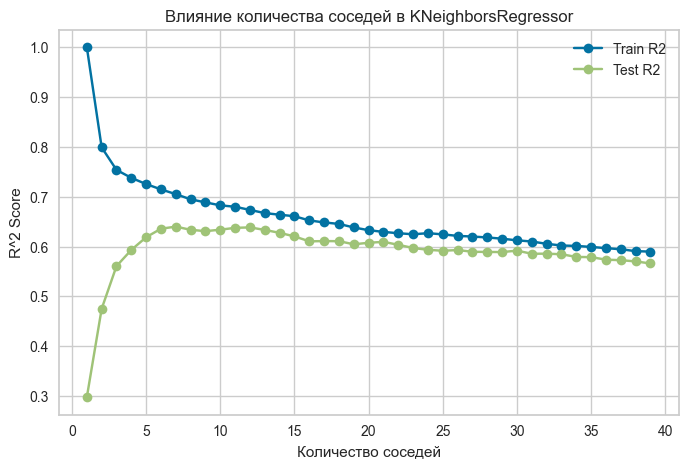

In [35]:
neighbors = range(1,40)
train_scores_knn = []
test_scores_knn = []

for n in neighbors:
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    train_scores_knn.append(r2_score(y_train, knn.predict(X_train)))
    test_scores_knn.append(r2_score(y_test, knn.predict(X_test)))
    print(f"n_neighbors={n}: Train R2={train_scores_knn[-1]:.4f}, Test R2={test_scores_knn[-1]:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(neighbors, train_scores_knn, label='Train R2', marker='o')
plt.plot(neighbors, test_scores_knn, label='Test R2', marker='o')
plt.xlabel("Количество соседей")
plt.ylabel("R^2 Score")
plt.title("Влияние количества соседей в KNeighborsRegressor")
plt.legend()
plt.show()

###### 3. метода решающих деревьев (гиперпараметры по вашему выбору)

max_depth=2: Train R2=0.3190, Test R2=0.2756
max_depth=3: Train R2=0.4730, Test R2=0.3438
max_depth=4: Train R2=0.5976, Test R2=0.4375
max_depth=5: Train R2=0.7116, Test R2=0.4578
max_depth=6: Train R2=0.8043, Test R2=0.4381
max_depth=7: Train R2=0.8838, Test R2=0.4673
max_depth=8: Train R2=0.9319, Test R2=0.4627
max_depth=9: Train R2=0.9635, Test R2=0.4674
max_depth=10: Train R2=0.9800, Test R2=0.4831
max_depth=11: Train R2=0.9903, Test R2=0.4438
max_depth=12: Train R2=0.9959, Test R2=0.4680
max_depth=13: Train R2=0.9984, Test R2=0.4920
max_depth=14: Train R2=0.9995, Test R2=0.4814
max_depth=15: Train R2=0.9999, Test R2=0.4940
max_depth=16: Train R2=1.0000, Test R2=0.4629
max_depth=17: Train R2=1.0000, Test R2=0.4744
max_depth=18: Train R2=1.0000, Test R2=0.4935
max_depth=19: Train R2=1.0000, Test R2=0.4830
max_depth=20: Train R2=1.0000, Test R2=0.4830
max_depth=None: Train R2=1.0000, Test R2=0.4830


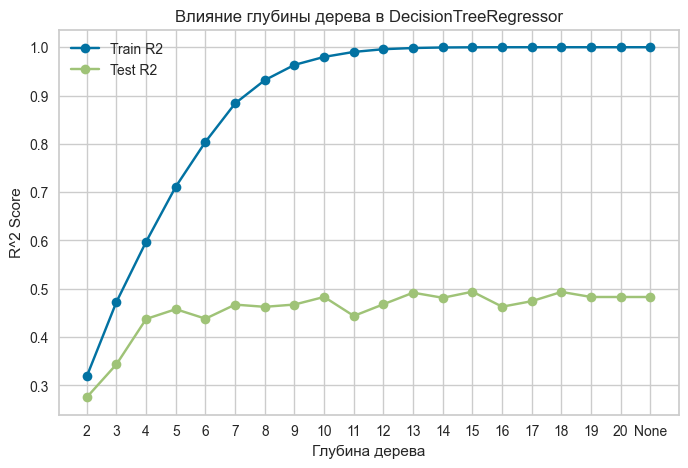

In [36]:
depth_values = [*range(2,21), None]
train_scores_tree = []
test_scores_tree = []

for depth in depth_values:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    train_scores_tree.append(r2_score(y_train, tree.predict(X_train)))
    test_scores_tree.append(r2_score(y_test, tree.predict(X_test)))
    print(f"max_depth={depth}: Train R2={train_scores_tree[-1]:.4f}, Test R2={test_scores_tree[-1]:.4f}")

plt.figure(figsize=(8, 5))
plt.plot([str(d) for d in depth_values], train_scores_tree, label='Train R2', marker='o')
plt.plot([str(d) for d in depth_values], test_scores_tree, label='Test R2', marker='o')
plt.xlabel("Глубина дерева")
plt.ylabel("R^2 Score")
plt.title("Влияние глубины дерева в DecisionTreeRegressor")
plt.legend()
plt.show()


##### 3. Дополните анализ датасета Бостон исследованием модели лассо - постройте кривые обучения для переобученной, недообученной и качественной модели, найдите оптимальное значение параметра регуляризации в модели лассо.


Оптимальное значение alpha: 0.0001
Лучший R^2: 0.7244300952414544


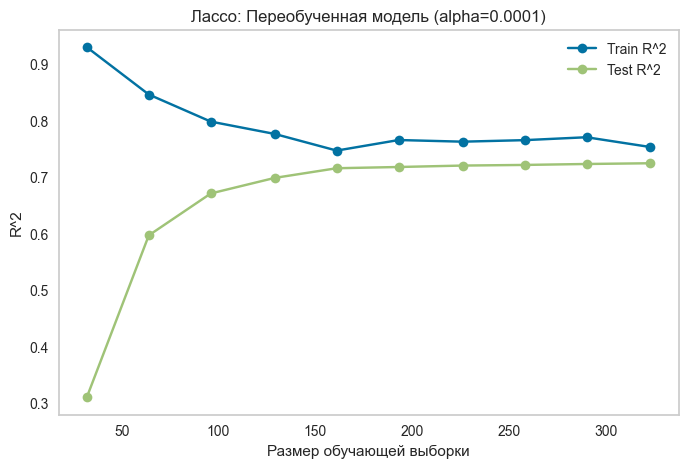

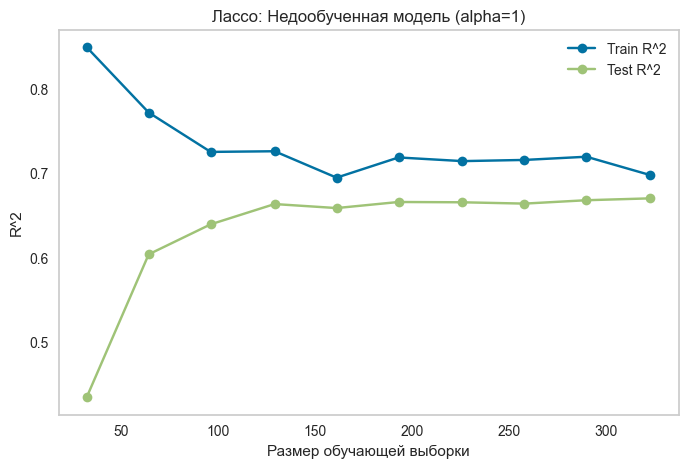

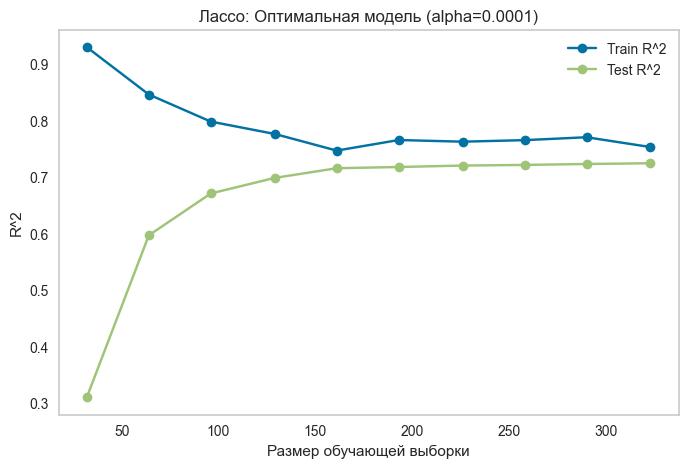

In [37]:


data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X_boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y_boston = raw_df.values[1::2, 2]

# Разделение на обучающую и тестовую выборки
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_boston, y_boston, test_size=0.2, random_state=42)

# Подбор оптимального значения alpha через GridSearchCV
alphas = np.logspace(-4, 0, 50)
param_grid = {'alpha': alphas}
lasso = Lasso(max_iter=10000)
grid = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')
grid.fit(X_train_b, y_train_b)
print("Оптимальное значение alpha:", grid.best_params_['alpha'])
print("Лучший R^2:", grid.best_score_)

# Функция для построения кривых обучения
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5,
                                                            train_sizes=np.linspace(0.1, 1.0, 10),
                                                            scoring='r2')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Train R^2")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Test R^2")
    plt.title(title)
    plt.xlabel("Размер обучающей выборки")
    plt.ylabel("R^2")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Модель с переобучением (слабая регуляризация)
lasso_over = Lasso(alpha=0.0001, max_iter=10000)
plot_learning_curve(lasso_over, X_train_b, y_train_b, "Лассо: Переобученная модель (alpha=0.0001)")

# Модель с недообучением (сильная регуляризация)
lasso_under = Lasso(alpha=1, max_iter=10000)
plot_learning_curve(lasso_under, X_train_b, y_train_b, "Лассо: Недообученная модель (alpha=1)")

# Оптимальная модель с подобранным alpha
lasso_opt = Lasso(alpha=grid.best_params_['alpha'], max_iter=10000)
plot_learning_curve(lasso_opt, X_train_b, y_train_b, f"Лассо: Оптимальная модель (alpha={grid.best_params_['alpha']})")


##### 4. В одном из двух первых примеров используйте модель ElasticNet и исследуйте влияние сразу двух параметров регуляризации на эффективность модели.

In [38]:
# Используем датасет Бостон
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_boston, y_boston, test_size=0.2, random_state=42)

# Определение диапазонов для параметров
param_grid_en = {
    'alpha': np.logspace(-4, 0, 30),
    'l1_ratio': np.linspace(0.1, 0.9, 9)
}

elastic_net = ElasticNet(max_iter=10000)
grid_en = GridSearchCV(elastic_net, param_grid_en, cv=5, scoring='r2')
grid_en.fit(X_train_e, y_train_e)

print("Оптимальные параметры ElasticNet:")
print(grid_en.best_params_)
print("Лучший R^2:", grid_en.best_score_)

# Оценка на тестовой выборке
best_en = grid_en.best_estimator_
y_pred_en = best_en.predict(X_test_e)
print("Тестовый R^2:", r2_score(y_test_e, y_pred_en))

Оптимальные параметры ElasticNet:
{'alpha': 0.0001, 'l1_ratio': 0.9}
Лучший R^2: 0.7244219435187447
Тестовый R^2: 0.6687593572789853


##### 5. Дополните анализ дерева решений из третьего примера: постройте кривые регуляризации для полного датасета, найдите оптимальную глубину дерева и оцените качество такой модели на всем датасете. Повторите данный анализ используя в качестве метрики эффективности F1.


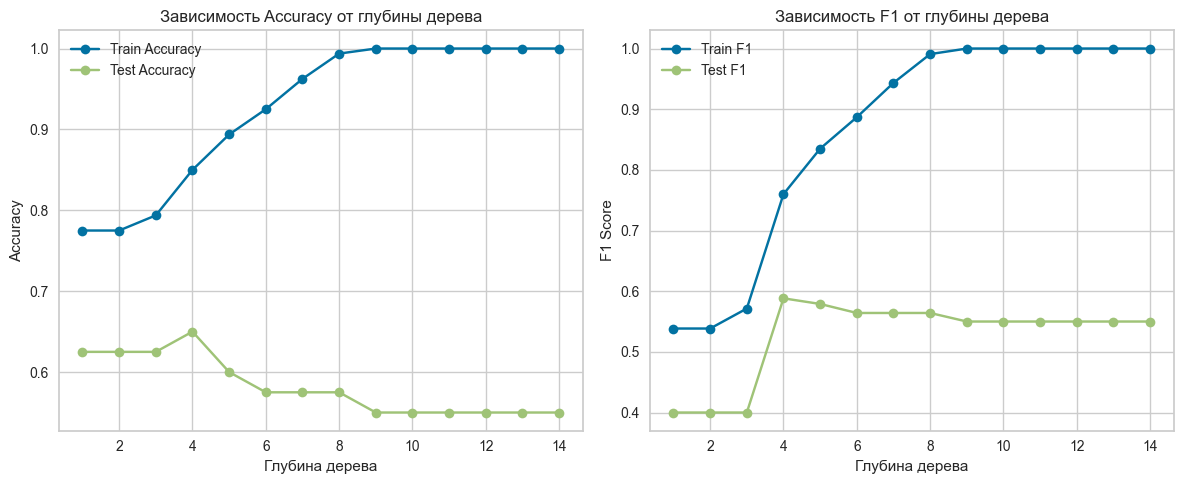

Оптимальная глубина дерева по F1 на тестовой выборке: 4
Качество модели на полном датасете:
Accuracy: 0.795
F1 Score: 0.6238532110091743


In [39]:
# Загрузка полного датасета diabetes.csv
data =  pd.read_csv('https://raw.githubusercontent.com/koroteevmv/ML_course/2023/ML4.3%20diagnostics/diabetes.csv',nrows=200)

# Разделение признаков и целевой переменной
X_diabetes = data.drop(columns=['Outcome'])
y_diabetes = data['Outcome']

# Разделение на обучающую и тестовую выборки
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_diabetes, y_diabetes, test_size=0.2, random_state=42)

# Исследование зависимости метрик от глубины дерева
depths = range(1, 15)
train_acc = []
test_acc = []
train_f1 = []
test_f1 = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train_d, y_train_d)
    y_train_pred = clf.predict(X_train_d)
    y_test_pred = clf.predict(X_test_d)
    
    train_acc.append(accuracy_score(y_train_d, y_train_pred))
    test_acc.append(accuracy_score(y_test_d, y_test_pred))
    train_f1.append(f1_score(y_train_d, y_train_pred))
    test_f1.append(f1_score(y_test_d, y_test_pred))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(depths, train_acc, label="Train Accuracy", marker='o')
plt.plot(depths, test_acc, label="Test Accuracy", marker='o')
plt.xlabel("Глубина дерева")
plt.ylabel("Accuracy")
plt.title("Зависимость Accuracy от глубины дерева")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(depths, train_f1, label="Train F1", marker='o')
plt.plot(depths, test_f1, label="Test F1", marker='o')
plt.xlabel("Глубина дерева")
plt.ylabel("F1 Score")
plt.title("Зависимость F1 от глубины дерева")
plt.legend()

plt.tight_layout()
plt.show()

# Определение оптимальной глубины по максимальному F1 на тестовой выборке
optimal_depth = depths[test_f1.index(max(test_f1))]
print("Оптимальная глубина дерева по F1 на тестовой выборке:", optimal_depth)

# Обучение модели с оптимальной глубиной на полном датасете
clf_opt = DecisionTreeClassifier(max_depth=optimal_depth, random_state=42)
clf_opt.fit(X_diabetes, y_diabetes)
y_pred_full = clf_opt.predict(X_diabetes)
full_accuracy = accuracy_score(y_diabetes, y_pred_full)
full_f1 = f1_score(y_diabetes, y_pred_full)

print("Качество модели на полном датасете:")
print("Accuracy:", full_accuracy)
print("F1 Score:", full_f1)

##### 6. Повторите анализ на других реальных датасетах из репозитория OpenML:
    - phoneme
    - banknote-authentication
    - delta_ailerons
    - mammography
    - electricity
    - mozilla4
    - kropt
    - nursery
    - volcanoes-b3

In [44]:
# Список датасетов OpenML
datasets = ["phoneme", "banknote-authentication", "delta_ailerons", 
            "mammography", "electricity", "mozilla4", "kropt", 
            "nursery", "volcanoes-b3"]

for ds in datasets:
    print(f"\nАнализ датасета: {ds}")
    try:
        data_oml = fetch_openml(ds, version=1, as_frame=True)

        X_oml = data_oml.data
        y_oml = data_oml.target
        le = LabelEncoder()
        y_oml = le.fit_transform(y_oml)
        
        if 'category' in X_oml.dtypes.values:
            X_oml = pd.get_dummies(X_oml)
                
        X_train_oml, X_test_oml, y_train_oml, y_test_oml = train_test_split(X_oml, y_oml, test_size=0.2, random_state=42)
        
        
        model = LogisticRegression(max_iter=1000, solver='liblinear')
        model.fit(X_train_oml, y_train_oml)
        y_pred = model.predict(X_test_oml)
        acc = accuracy_score(y_test_oml, y_pred)
        f1 = f1_score(y_test_oml, y_pred, average='weighted')
        print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    except Exception as e:
        print("Ошибка при загрузке или анализе датасета:", ds, e)



Анализ датасета: phoneme
Accuracy: 0.7558, F1 Score: 0.7447

Анализ датасета: banknote-authentication
Accuracy: 0.9855, F1 Score: 0.9855

Анализ датасета: delta_ailerons
Accuracy: 0.5835, F1 Score: 0.4831

Анализ датасета: mammography
Accuracy: 0.9857, F1 Score: 0.9832

Анализ датасета: electricity
Accuracy: 0.7542, F1 Score: 0.7481

Анализ датасета: mozilla4
Accuracy: 0.8549, F1 Score: 0.8543

Анализ датасета: kropt
Accuracy: 0.3658, F1 Score: 0.3368

Анализ датасета: nursery
Accuracy: 0.9186, F1 Score: 0.9076

Анализ датасета: volcanoes-b3
Accuracy: 0.9639, F1 Score: 0.9471


#### Контрольные вопросы

1. Что такое обобщающая способность модели?
2. Что такое переобучение модели?
3. Какие есть способы борьбы с переобучением?
4. Что такое регуляризация модели, как она работает?
1. Чем отличаются разные методы регуляризации моделей?
5. Что такое недообучение модели?
6. Какие есть способы борьбы с недообучением?

#### Дополнительные задания

1. Повторите анализ последнего примера но с другими разделениями датасета на обучающую и тестовую выборки (изменяйте параметр random_state). Как меняется вид графиков?
1. Напишите код построения кривых регуляризации, использующий кросс-валидацию.